# Custom Transformer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

path = 'NLP'

os.chdir(f'/content/drive/MyDrive/{path}')
os.getcwd()

'/content/drive/MyDrive/NLP'

In [ ]:
!pip install datasets
import json
import random

Setting the seed in order to make the training reproducible

In [ ]:
import torch

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

Loading the final_dataset.json already created

In [ ]:
import json

output_file = "final_dataset.json"

with open(output_file, "r") as f:
    final_dataset = json.load(f)

print(f"Dataset loaded: {len(final_dataset)} elements")

Dataset loaded: 332960 elements


In [ ]:
final_dataset

[{'solution_code': "<IMPORTS_START>\nimport sys\n<IMPORTS_END>\n\n<FUNC_DEF_START>\ndef func_0():\n    return list(map(int, sys.stdin.readline().strip().split()))\n<FUNC_DEF_END>\n\n<FUNC_DEF_START>\ndef func_1():\n    return map(int, sys.stdin.readline().strip().split())\n<FUNC_DEF_END>\n\n<FUNC_DEF_START>\ndef func_2():\n    return sys.stdin.readline().strip()\n<FUNC_DEF_END>\n\n<GLOBAL_CODE_START>\nvar_0 = func_2()\nvar_1 = [var_2 for var_2, var_3 in enumerate(var_0, 1) if var_3 == '1']\nvar_4 = int(func_2())\nvar_5 = 'NO'\nvar_6 = [(-1, 0, 0, [])]\nwhile var_6:\n    var_7, var_8, var_9, var_10 = var_6.pop()\n    if var_8 == var_4:\n        print('YES')\n        print(*var_10)\n        exit()\n    for var_11 in var_1:\n        if var_11 != var_7 and var_11 > var_9:\n            var_6.append((var_11, var_8 + 1, var_11 - var_9, var_10 + [var_11])\n                )\nprint(var_5)\n<GLOBAL_CODE_END>",
  'time_complexity': 'O(1)'},
 {'solution_code': "<GLOBAL_CODE_START>\nvar_0, var_1 = 

### Tokenizer

We use the tokenizer of codeBERT, so a suitable tokenizer for our task.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# CodeBERT already has the special tokens, but it is good practice to specify them
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

1

Check the CLS token of the tokenizer

In [ ]:
print("CLS token:", tokenizer.cls_token)
print("CLS token ID:", tokenizer.cls_token_id)

CLS token: <s>
CLS token ID: 0


Check how the tokenizer handles our added special tokens

In [ ]:
print(tokenizer.tokenize("<IMPORTS_START>"))
print(tokenizer.tokenize("<IMPORTS_END>"))
print(tokenizer.tokenize("<FUNC_DEF_START>"))
print(tokenizer.tokenize("<FUNC_DEF_END>"))
print(tokenizer.tokenize("<GLOBAL_CODE_START>"))
print(tokenizer.tokenize("<GLOBAL_CODE_END>"))

['<', 'IM', 'P', 'ORTS', '_', 'ST', 'ART', '>']
['<', 'IM', 'P', 'ORTS', '_', 'END', '>']
['<', 'FUN', 'C', '_', 'DEF', '_', 'ST', 'ART', '>']
['<', 'FUN', 'C', '_', 'DEF', '_', 'END', '>']
['<', 'GL', 'OB', 'AL', '_', 'C', 'ODE', '_', 'ST', 'ART', '>']
['<', 'GL', 'OB', 'AL', '_', 'C', 'ODE', '_', 'END', '>']


We add the special_tags on the tokenizer, so that the single tags is treated as a single token and to help the model to recognize the structure.

In [ ]:
my_special_tags = ['<IMPORTS_START>', '<IMPORTS_END>',
                   '<FUNC_DEF_START>', '<FUNC_DEF_END>',
                   '<GLOBAL_CODE_START>', '<GLOBAL_CODE_END>'
                    ]


special_tokens_dict = {'additional_special_tokens': my_special_tags}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
print(f"Original Vocabulary: {tokenizer.vocab_size - num_added_toks}")
print(f"Added {num_added_toks} new tokens.")
print(f"New dimension of the tokenizer's vocabulary: {len(tokenizer)}")

Original Vocabulary: 50259
Added 6 new tokens.
New dimension of the tokenizer's vocabulary: 50272


Now the tokenizer handles the tags like special tokens! The model can identify different structure on the codes

In [ ]:
print(tokenizer.tokenize("<IMPORTS_START>"))
print(tokenizer.tokenize("<IMPORTS_END>"))
print(tokenizer.tokenize("<FUNC_DEF_START>"))
print(tokenizer.tokenize("<FUNC_DEF_END>"))
print(tokenizer.tokenize("<GLOBAL_CODE_START>"))
print(tokenizer.tokenize("<GLOBAL_CODE_END>"))

['<IMPORTS_START>']
['<IMPORTS_END>']
['<FUNC_DEF_START>']
['<FUNC_DEF_END>']
['<GLOBAL_CODE_START>']
['<GLOBAL_CODE_END>']


Filtering our dataset considering only the input codes with max 512 tokens.

In [ ]:
MAX_TOKENS = 512

final_dataset = [
    entry for entry in final_dataset
    if len(tokenizer.tokenize(entry['solution_code'])) <= MAX_TOKENS
]

print(f"Total number of example after filtering: {len(final_dataset)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


Total number of example after filtering: 311194


Let's try it with a code example:

In [ ]:
example = final_dataset[0]
print("Code extracted: ", example['solution_code'])
tokenized_example = tokenizer(example['solution_code'], padding='max_length', truncation=True, max_length=512)

print("Input IDs:", tokenized_example['input_ids'])
print("Attention Mask:", tokenized_example['attention_mask'])


Code extracted:  <IMPORTS_START>
import sys
<IMPORTS_END>

<FUNC_DEF_START>
def func_0():
    return list(map(int, sys.stdin.readline().strip().split()))
<FUNC_DEF_END>

<FUNC_DEF_START>
def func_1():
    return map(int, sys.stdin.readline().strip().split())
<FUNC_DEF_END>

<FUNC_DEF_START>
def func_2():
    return sys.stdin.readline().strip()
<FUNC_DEF_END>

<GLOBAL_CODE_START>
var_0 = func_2()
var_1 = [var_2 for var_2, var_3 in enumerate(var_0, 1) if var_3 == '1']
var_4 = int(func_2())
var_5 = 'NO'
var_6 = [(-1, 0, 0, [])]
while var_6:
    var_7, var_8, var_9, var_10 = var_6.pop()
    if var_8 == var_4:
        print('YES')
        print(*var_10)
        exit()
    for var_11 in var_1:
        if var_11 != var_7 and var_11 > var_9:
            var_6.append((var_11, var_8 + 1, var_11 - var_9, var_10 + [var_11])
                )
print(var_5)
<GLOBAL_CODE_END>
Input IDs: [0, 50266, 50118, 41975, 47427, 50118, 50267, 50140, 50268, 50118, 9232, 26437, 1215, 288, 49536, 50118, 1437, 1437,

In [ ]:
unique_classes = sorted(set(example['time_complexity'] for example in final_dataset))
print(unique_classes)

['O(1)', 'O(logn)', 'O(n)', 'O(n**2)', 'O(n*m)', 'O(n+m)', 'O(nlogn)']


Creating Mapping Class -> Integer number

In [ ]:
label2id = {label: idx for idx, label in enumerate(unique_classes)}
id2label = {idx: label for label, idx in label2id.items()}

Let's now convert each "time_complexity" into a numeric "label" field, which we will use during training:

In [ ]:
for example in final_dataset:
    example['label'] = label2id[example['time_complexity']]

Creating The tokenized dataset

80% Training, 10% Validation, 10% Test

In [ ]:
from datasets import Dataset, DatasetDict


random.shuffle(final_dataset)

split = int(0.8 * len(final_dataset))
train_data = final_dataset[:split]
val_data = final_dataset[split:]    #20% Data, Val + Test

#10% Validation, 10% Test
val_split = len(val_data) // 2
val_data, test_data = val_data[:val_split], val_data[val_split:]


dataset = DatasetDict({
    'train': Dataset.from_list(train_data),
    'validation': Dataset.from_list(val_data),
    'test': Dataset.from_list(test_data)
})

def tokenize_function(examples):
    tokenized = tokenizer(
        examples['solution_code'],
        padding='max_length',
        truncation=True,
        max_length=512,
        add_special_tokens=True
    )
    tokenized['label'] = examples['label']
    return tokenized


tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/248955 [00:00<?, ? examples/s]

Map:   0%|          | 0/31119 [00:00<?, ? examples/s]

Map:   0%|          | 0/31120 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['solution_code', 'time_complexity', 'label', 'input_ids', 'attention_mask'],
        num_rows: 248955
    })
    validation: Dataset({
        features: ['solution_code', 'time_complexity', 'label', 'input_ids', 'attention_mask'],
        num_rows: 31119
    })
    test: Dataset({
        features: ['solution_code', 'time_complexity', 'label', 'input_ids', 'attention_mask'],
        num_rows: 31120
    })
})

### Create the model

Collate + dataLoader functions

In [ ]:
import torch
from torch.utils.data import DataLoader


train_data = tokenized_dataset['train']
val_data = tokenized_dataset['validation']
test_data = tokenized_dataset['test']


def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item['input_ids']) for item in batch])
    attention_mask = torch.stack([torch.tensor(item['attention_mask']) for item in batch])
    labels = torch.stack([torch.tensor(item['label']) for item in batch])

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True,
                              collate_fn=collate_fn, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=64,
                            collate_fn=collate_fn, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=64,
                            collate_fn=collate_fn, num_workers=4, pin_memory=True)

Declaring the transformer: d_model = 256, nhead=8, num_layers = 4

In [ ]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]  # broadcast over batch
        return x

class ComplexityClassifier(nn.Module):
    def __init__(self, vocab_size, num_labels, d_model=256, nhead=8, num_layers=4, max_len=512, dropout=0.4):
        super(ComplexityClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_labels)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)                  # [B, L, D]
        x = self.pos_encoder(x)                        # [B, L, D]

        attn_mask = attention_mask == 0                # [B, L] boolean mask
        x = self.transformer_encoder(x, src_key_padding_mask=attn_mask)

        x = x[:, 0, :]     # [CLS] token embedding
        x = self.layer_norm(x)
        x = self.dropout(x)
        logits = self.classifier(x)                    # [B, num_labels]
        return logits

Declaring the model

In [ ]:
vocab_size = tokenizer.get_vocab().__len__()

model = ComplexityClassifier(
    vocab_size=vocab_size,
    num_labels=len(label2id),
    d_model=256,
    nhead=8,
    num_layers=4
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ComplexityClassifier(
  (embedding): Embedding(50272, 256)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (classifier): Linear(in_features=256, out_features=7, bias=True)
)

Check that the model is ok with the dataset:

In [ ]:
batch = next(iter(train_dataloader))

input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)
labels = batch['labels'].to(device)

# Forward pass with the model
logits = model(input_ids=input_ids, attention_mask=attention_mask)

print(logits.shape)  # It has to be [batch_size, num_labels]

torch.Size([64, 7])


### Loop Training

**Implementing Class Weights** \\
In order to better handle the balancing classes during training and to make sure that the model also considers less populated classes, we introduce the class_weights to be inserted in the loss function, in order to more penalize errors on smaller classes.

In [ ]:
import torch
import torch.nn as nn
from collections import Counter

# Count classes
label_counts = Counter(example['label'] for example in final_dataset)
total_samples = sum(label_counts.values())
num_classes = len(label_counts)

class_weights = [total_samples / (num_classes * label_counts[i]) for i in range(num_classes)]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Balanced Loss
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)

In [ ]:
print(class_weights)

[0.8436047993146935, 2.4086409337533574, 0.8195462386263381, 0.8749859414715343, 0.9143621084797555, 1.3800728188708198, 0.8209385576844443]


Optmize training with cuDNN because input of fixed dimension

In [ ]:
torch.backends.cudnn.benchmark = True

<ipython-input-27-d9160b6afb94>:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/60:   0%|          | 0/3890 [00:00<?, ?it/s]<ipython-input-27-d9160b6afb94>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/60: 100%|██████████| 3890/3890 [02:35<00:00, 24.96it/s, loss=1.1]


Epoch 1 completed.
Average Training Loss: 1.3937
Training Accuracy: 0.5693



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Validation Accuracy: 0.6571
Current LR: 1.00e-04
✓ New model saved (best_model.pt)


Epoch 2/60: 100%|██████████| 3890/3890 [02:35<00:00, 24.95it/s, loss=0.983]


Epoch 2 completed.
Average Training Loss: 1.1764
Training Accuracy: 0.6811


Validation Accuracy: 0.7032
Current LR: 1.00e-04
✓ New model saved (best_model.pt)


Epoch 3/60: 100%|██████████| 3890/3890 [02:35<00:00, 25.03it/s, loss=1.12]


Epoch 3 completed.
Average Training Loss: 1.1041
Training Accuracy: 0.7169


Validation Accuracy: 0.7316
Current LR: 1.00e-04
✓ New model saved (best_model.pt)


Epoch 4/60: 100%|██████████| 3890/3890 [02:32<00:00, 25.51it/s, loss=1.18]


Epoch 4 completed.
Average Training Loss: 1.0559
Training Accuracy: 0.7403


Validation Accuracy: 0.7521
Current LR: 1.00e-04
✓ New model saved (best_model.pt)


Epoch 5/60: 100%|██████████| 3890/3890 [02:31<00:00, 25.61it/s, loss=1.02]


Epoch 5 completed.
Average Training Loss: 1.0191
Training Accuracy: 0.7574


Validation Accuracy: 0.7660
Current LR: 1.00e-04
✓ New model saved (best_model.pt)


Epoch 6/60: 100%|██████████| 3890/3890 [02:32<00:00, 25.52it/s, loss=1.03]


Epoch 6 completed.
Average Training Loss: 0.9913
Training Accuracy: 0.7715


Validation Accuracy: 0.7744
Current LR: 1.00e-04
✓ New model saved (best_model.pt)


Epoch 7/60: 100%|██████████| 3890/3890 [02:32<00:00, 25.57it/s, loss=1.06]


Epoch 7 completed.
Average Training Loss: 0.9668
Training Accuracy: 0.7829


Validation Accuracy: 0.7847
Current LR: 1.00e-04
✓ New model saved (best_model.pt)


Epoch 8/60: 100%|██████████| 3890/3890 [02:32<00:00, 25.58it/s, loss=0.996]


Epoch 8 completed.
Average Training Loss: 0.9455
Training Accuracy: 0.7920


Validation Accuracy: 0.7829
Current LR: 1.00e-04
No improvement for 1 epoch(s).


Epoch 9/60: 100%|██████████| 3890/3890 [02:32<00:00, 25.57it/s, loss=0.875]


Epoch 9 completed.
Average Training Loss: 0.9277
Training Accuracy: 0.8004


Validation Accuracy: 0.7917
Current LR: 1.00e-04
✓ New model saved (best_model.pt)


Epoch 10/60: 100%|██████████| 3890/3890 [02:32<00:00, 25.57it/s, loss=1.01]


Epoch 10 completed.
Average Training Loss: 0.9120
Training Accuracy: 0.8074


Validation Accuracy: 0.7899
Current LR: 1.00e-04
No improvement for 1 epoch(s).


Epoch 11/60: 100%|██████████| 3890/3890 [02:32<00:00, 25.57it/s, loss=0.862]


Epoch 11 completed.
Average Training Loss: 0.8968
Training Accuracy: 0.8156


Validation Accuracy: 0.7980
Current LR: 1.00e-04
✓ New model saved (best_model.pt)


Epoch 12/60: 100%|██████████| 3890/3890 [02:33<00:00, 25.40it/s, loss=1.03]


Epoch 12 completed.
Average Training Loss: 0.8833
Training Accuracy: 0.8218


Validation Accuracy: 0.7993
Current LR: 1.00e-04
✓ New model saved (best_model.pt)


Epoch 13/60: 100%|██████████| 3890/3890 [02:36<00:00, 24.84it/s, loss=0.896]


Epoch 13 completed.
Average Training Loss: 0.8704
Training Accuracy: 0.8279


Validation Accuracy: 0.8056
Current LR: 1.00e-04
✓ New model saved (best_model.pt)


Epoch 14/60: 100%|██████████| 3890/3890 [02:35<00:00, 24.96it/s, loss=0.86]


Epoch 14 completed.
Average Training Loss: 0.8595
Training Accuracy: 0.8330


Validation Accuracy: 0.7990
Current LR: 1.00e-04
No improvement for 1 epoch(s).


Epoch 15/60: 100%|██████████| 3890/3890 [02:33<00:00, 25.42it/s, loss=0.699]


Epoch 15 completed.
Average Training Loss: 0.8495
Training Accuracy: 0.8377


Validation Accuracy: 0.8113
Current LR: 1.00e-04
✓ New model saved (best_model.pt)


Epoch 16/60: 100%|██████████| 3890/3890 [02:32<00:00, 25.46it/s, loss=0.943]


Epoch 16 completed.
Average Training Loss: 0.8372
Training Accuracy: 0.8435


Validation Accuracy: 0.8104
Current LR: 1.00e-04
No improvement for 1 epoch(s).


Epoch 17/60: 100%|██████████| 3890/3890 [02:32<00:00, 25.54it/s, loss=0.933]


Epoch 17 completed.
Average Training Loss: 0.8282
Training Accuracy: 0.8481


Validation Accuracy: 0.8120
Current LR: 1.00e-04
✓ New model saved (best_model.pt)


Epoch 18/60: 100%|██████████| 3890/3890 [02:32<00:00, 25.49it/s, loss=0.876]


Epoch 18 completed.
Average Training Loss: 0.8199
Training Accuracy: 0.8518


Validation Accuracy: 0.8118
Current LR: 1.00e-04
No improvement for 1 epoch(s).


Epoch 19/60: 100%|██████████| 3890/3890 [02:32<00:00, 25.53it/s, loss=1.04]


Epoch 19 completed.
Average Training Loss: 0.8110
Training Accuracy: 0.8559


Validation Accuracy: 0.8152
Current LR: 1.00e-04
✓ New model saved (best_model.pt)


Epoch 20/60: 100%|██████████| 3890/3890 [02:32<00:00, 25.54it/s, loss=0.703]


Epoch 20 completed.
Average Training Loss: 0.8027
Training Accuracy: 0.8593


Validation Accuracy: 0.8091
Current LR: 1.00e-04
No improvement for 1 epoch(s).


Epoch 21/60: 100%|██████████| 3890/3890 [02:32<00:00, 25.53it/s, loss=0.822]


Epoch 21 completed.
Average Training Loss: 0.7949
Training Accuracy: 0.8639


Validation Accuracy: 0.8203
Current LR: 1.00e-04
✓ New model saved (best_model.pt)


Epoch 22/60: 100%|██████████| 3890/3890 [02:33<00:00, 25.36it/s, loss=0.704]


Epoch 22 completed.
Average Training Loss: 0.7860
Training Accuracy: 0.8677


Validation Accuracy: 0.8178
Current LR: 1.00e-04
No improvement for 1 epoch(s).


Epoch 23/60: 100%|██████████| 3890/3890 [02:32<00:00, 25.43it/s, loss=0.729]


Epoch 23 completed.
Average Training Loss: 0.7803
Training Accuracy: 0.8708


Validation Accuracy: 0.8166
Current LR: 1.00e-04
No improvement for 2 epoch(s).


Epoch 24/60: 100%|██████████| 3890/3890 [02:33<00:00, 25.40it/s, loss=0.647]


Epoch 24 completed.
Average Training Loss: 0.7709
Training Accuracy: 0.8752


Validation Accuracy: 0.8148
Current LR: 5.00e-05
No improvement for 3 epoch(s).
⏹️ Early stopping triggered.


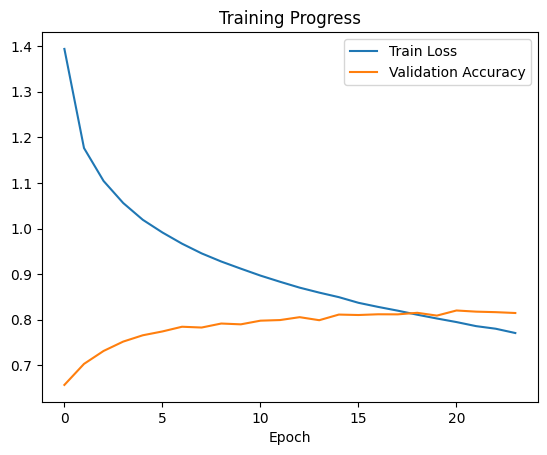

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torch.cuda.amp import autocast, GradScaler

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

best_accuracy = 0.0
num_epochs = 10
patience = 3
delta = 1e-4
epochs_without_improvement = 0

train_losses = []
val_accuracies = []

scaler = GradScaler()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        # Autocast for FP16
        with autocast():
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_dataloader)
    train_accuracy = correct / total
    train_losses.append(avg_loss)

    print(f"\nEpoch {epoch+1} completed.")
    print(f"Average Training Loss: {avg_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    val_accuracies.append(accuracy)

    print(f"Validation Accuracy: {accuracy:.4f}")

    # Scheduler update
    scheduler.step(accuracy)
    for param_group in optimizer.param_groups:
        print(f"Current LR: {param_group['lr']:.2e}")

    # Early stopping
    if accuracy > best_accuracy + delta:
        best_accuracy = accuracy
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("✓ New model saved (best_model.pt)")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s).")

    if epochs_without_improvement >= patience:
        print("⏹️ Early stopping triggered.")
        break

# Final Plot
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.title("Training Progress")
plt.show()

### Show graphically performance on TESTING set

In [ ]:
!pip install seaborn scikit-learn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
best_model = model
best_model.load_state_dict(torch.load("best_model.pt"))
best_model.to(device)
best_model.eval()

ComplexityClassifier(
  (embedding): Embedding(50272, 256)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (classifier): Linear(in_features=256, out_features=7, bias=True)
)

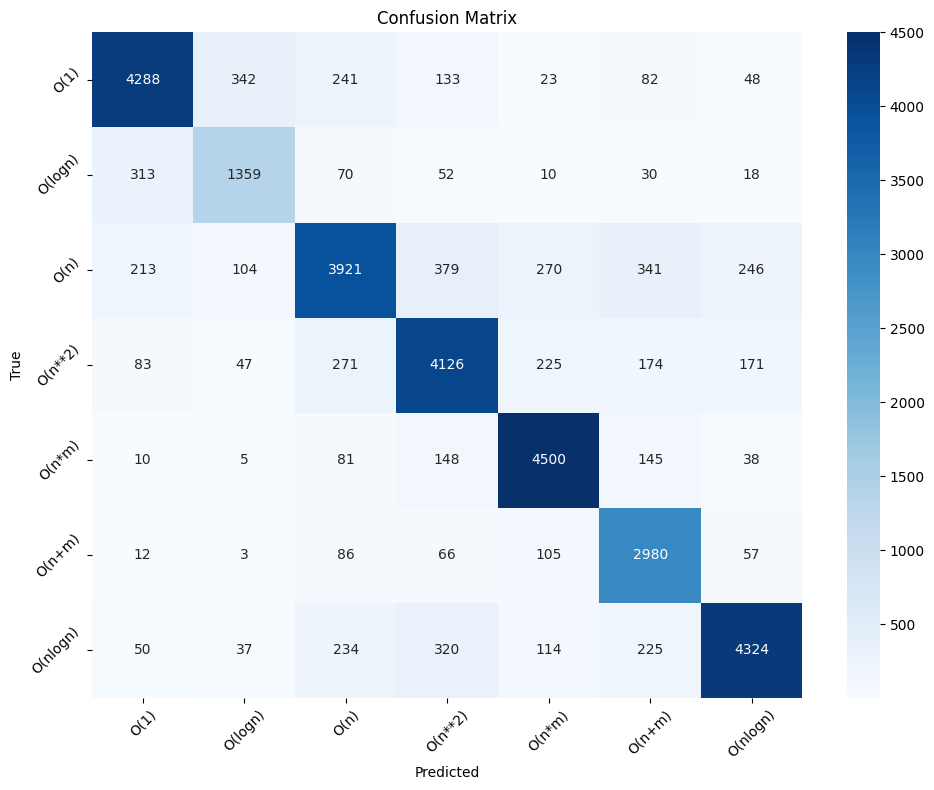

              precision    recall  f1-score   support

        O(1)       0.86      0.83      0.85      5157
     O(logn)       0.72      0.73      0.72      1852
        O(n)       0.80      0.72      0.76      5474
     O(n**2)       0.79      0.81      0.80      5097
      O(n*m)       0.86      0.91      0.88      4927
      O(n+m)       0.75      0.90      0.82      3309
    O(nlogn)       0.88      0.82      0.85      5304

    accuracy                           0.82     31120
   macro avg       0.81      0.82      0.81     31120
weighted avg       0.82      0.82      0.82     31120


In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = best_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())


cm = confusion_matrix(all_labels, all_preds)
class_names = [id2label[i] for i in range(len(id2label))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)
